In [1]:
from ase.io import read, write
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones
from castle import utils, LinearPotential, LPEnsemble, LPLocalEnsemble, print_score, AceRepresentation, ASEMLCalculator, ExpandedPotential
import dadapy

rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1, 'W':5.0, "P": 5.0}

%load_ext autoreload
%autoreload 2

In [2]:
# import os
# root = "/home/claudio/postdoc/data/P/P_test"
# test_traj = []
# for path, subdirs, files in os.walk(root):
#     for name in files:
#         if name.endswith(".xyz"):
#             traj_ = read(path + "/" + name, index = ':')
#             try:
#                 _ = [a.get_array("forces") for a in traj_]
#                 test_traj.extend(traj_)
#             except KeyError:
#                 print(f"{name} does not contain forces")
                
# write("/home/claudio/postdoc/data/P/test.xyz", test_traj)

bulk.xyz does not contain forces
bulk_all.xyz does not contain forces
Hittorf_Angew2020.vasp_STEPS.xyz does not contain forces
Hittorf_ActaB1969.vasp_STEPS.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces


/home/claudio/.local/lib/python3.8/site-packages/ase/io/extxyz.py:997: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [47]:
species = 'W'
N = 4
maxdeg = 12
rcut = rcuts[species]
force_name = 'force'
energy_name = 'energy'
e_noise = 1e-8
f_noise = 1e-8
root = f"/home/claudio/data/{species}/"

# tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz", 
#                                                    N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
#                                                    energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz", 
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",  f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

CPU times: user 106 ms, sys: 141 ms, total: 247 ms
Wall time: 31.2 ms
MAE=0.012 RMSE=0.016 SUP=0.050 R2=0.995
MAE=0.148 RMSE=0.217 SUP=2.557 R2=0.979


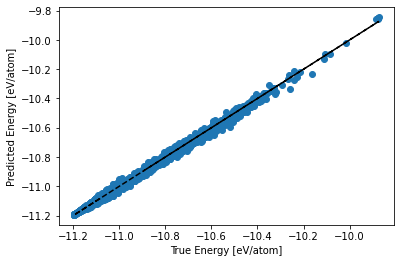

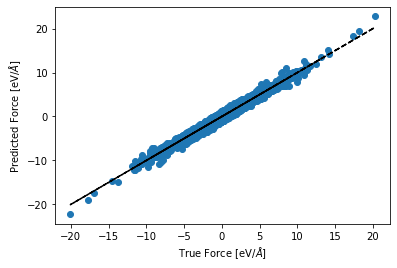

In [48]:
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_lin = LinearPotential(representation)
model_lin.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)

# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 244 ms, sys: 481 ms, total: 725 ms
Wall time: 124 ms
MAE=0.012 RMSE=0.015 SUP=0.060 R2=0.995


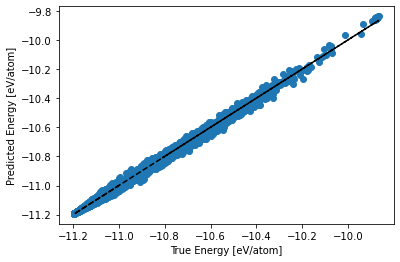

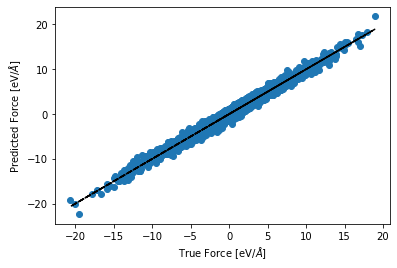

In [49]:
%time predictions = model_lin.predict_from_features(tr_features, forces=True)
et = predictions['energy']
ft = predictions['forces']
print_score(et/nat_tr, e_t/nat_tr)
# print_score(fp.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, et/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, ft)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

Clustering data
Using 17 clusters
CPU times: user 2.37 s, sys: 475 ms, total: 2.84 s
Wall time: 2.25 s
MAE=0.014 RMSE=0.037 SUP=0.097 R2=0.974
MAE=0.130 RMSE=0.191 SUP=1.769 R2=0.984


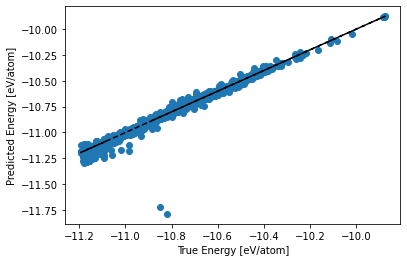

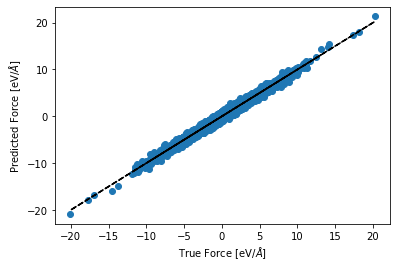

In [50]:
# train the model
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_ens = LPEnsemble(representation, n_clusters=17, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)
# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [51]:
old_alpha = model_ens.alphas

CPU times: user 8.89 s, sys: 0 ns, total: 8.89 s
Wall time: 8.89 s
MAE=0.012 RMSE=0.021 SUP=0.186 R2=0.991
MAE=0.128 RMSE=0.190 SUP=3.525 R2=0.983


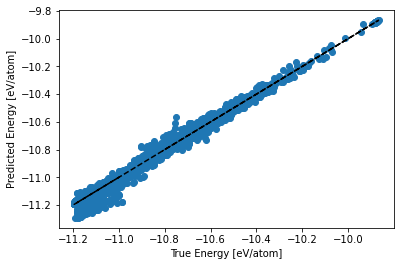

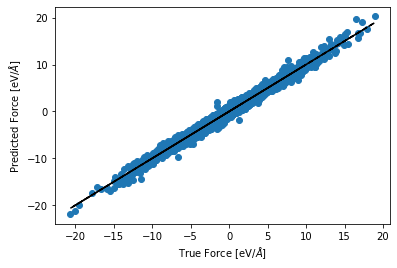

In [52]:
%time predictions = model_ens.predict_from_features(tr_features, forces=True)
et = predictions['energy']
ft = predictions['forces']
print_score(et/nat_tr, e_t/nat_tr)
print_score(ft.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, et/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, ft)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 2.39 s, sys: 489 ms, total: 2.88 s
Wall time: 2.27 s
MAE=0.014 RMSE=0.048 SUP=0.098 R2=0.956
MAE=0.130 RMSE=0.192 SUP=2.101 R2=0.984


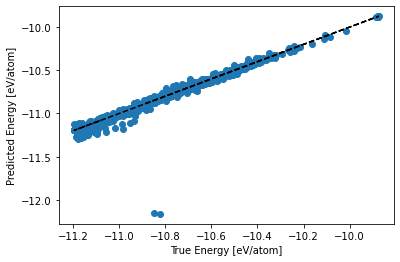

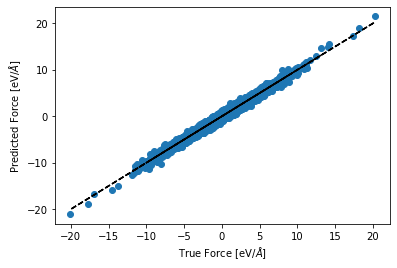

In [53]:
model_ens.update_from_features(val_features, ep, fp)# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [10]:
X = np.concatenate([tr_features.X, tr_features.X_std], axis =1)
Y = np.concatenate([val_features.X, val_features.X_std], axis =1)

In [11]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_ = (X - mean[None, :]) / std[None, :]
Y_ = (Y - mean[None, :]) / std[None, :]
data = dadapy.Data(X_)
dens_tr , dens_tr_err = data.compute_density_PAk()
data.compute_clustering_ADP(halo=False)
n_clusters = data.N_clusters
labels = data.cluster_assignment
dens_val, dens_val_err = data.return_interpolated_density_PAk(Y_)

101


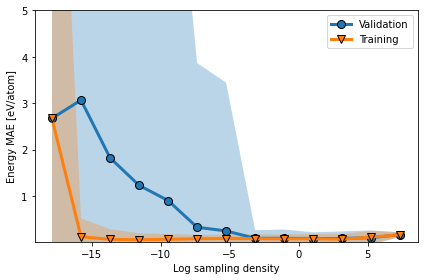

In [13]:
denss = dens_val
errss = abs((e_val/nat_val - ep/nat_val))

plt.figure(figsize = (6, 4))
low = -20
high = 20
scale = 'linear'
centers = np.linspace(low, high, 20)
binwidth = (high - low) / (len(centers))*2
binned_error = np.empty(len(centers))*np.nan
binned_error_std = np.empty(len(centers))*np.nan

for cc, c in enumerate(centers):
    ind = (denss < c + binwidth) & (denss > c - binwidth)
    if sum(ind)/len(denss) > 0.02:
        binned_error[cc] = np.mean(errss[ind])
        binned_error_std[cc] = np.std(errss[ind])
        
plt.plot(centers, binned_error, lw = 3,
         markersize = 8,mec = 'k', marker = 'o', label = 'Validation')
plt.fill_between(centers, binned_error + binned_error_std, binned_error - binned_error_std, alpha = 0.3)

denss = dens_tr
errss = abs((e_t/nat_tr - et/nat_tr))
for cc, c in enumerate(centers):
    ind = (denss < c + binwidth) & (denss > c - binwidth)
    if sum(ind)/len(denss) > 0.02:
        binned_error[cc] = np.mean(errss[ind])
        binned_error_std[cc] = np.std(errss[ind])
        
plt.plot(centers, binned_error, lw = 3,
         markersize = 8,mec = 'k', marker = 'v', label = 'Training')
plt.fill_between(centers, binned_error + binned_error_std, binned_error - binned_error_std, alpha = 0.3)
plt.xlabel("Log sampling density")
plt.ylabel("Energy MAE [eV/atom]")


plt.yscale(scale)
plt.legend()
plt.ylim(1e-2, 5)
plt.tight_layout()
# plt.savefig(f"../../plots/divide/energy_error_vs_sanpling_density_P_linear_{scale}.pdf")

In [14]:
np.argmin(dens_val)

43

In [15]:
val_features.get_subset([43])

In [26]:
model_ens.update_from_features(val_features, ep, fp)